# Предсказание возраста по фото

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: Сетевой супермаркет «Хлеб-Соль»**

**Проект заказчика: внедрение системы компьютерного зрения для обработки фотографий покупателей.**

 Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя. 

**Цель**

- Построить модель, определяющую возраст человека по фотографии, со значением MAE ≤ 8.

**Задачи**

- Выполнить исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.

**Описание данных**

Предоставлен набор фотографий людей с указанием возраста.

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

### Чтение файлов с данными

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

### Изучение общей информации о данных

In [4]:
labels.info()
display(labels.head())
if labels['file_name'].is_monotonic:
    print (color.BOLD+color.OKGREEN+'Выборка упорядочена по номеру фото'+color.END)
else:
    print (color.BOLD+color.FAIL+'Выборка не упорядочена по номеру фото'+color.END)
print(color.BOLD+'Размер выборки:', labels.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Выборка упорядочена по номеру фото
Размер выборки: (7591, 2)


- В выборке 7591 строка и 2 столбца:
    - `file_name` - наименование фотографии человека,
    - `real_age` - возраст человека.
- Пропуски отсутствуют.
- Выборка упорядочена по номеру фото.

## Исследовательский анализ данных (EDA)

### График распределения возраста в выборке

In [5]:
def hist_box (df: pd.DataFrame, col: 'name of column', bins: int):    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          gridspec_kw={'height_ratios': (.2, .8)},
                                          figsize=(18,8))
    fig.subplots_adjust(hspace=0.05)
    
    fig.suptitle(f'Распределение значений в признаке {col}', y=.912)
    
    sns.boxplot(x=df[col], ax=ax_box)
    sns.histplot(x=df[col], bins=bins, ax=ax_hist)
    
    ax_box.set(xlabel = '')
    ax_hist.axvline(df[col].mean(),color='orange',linestyle='-')
    ax_hist.axvline(df[col].median(),color='orchid',linestyle='--');
    
    ax_hist.legend(['среднее', 'медиана', 'распределение'],
                   loc='lower center',
                   bbox_to_anchor=[0.5, 0.5]);

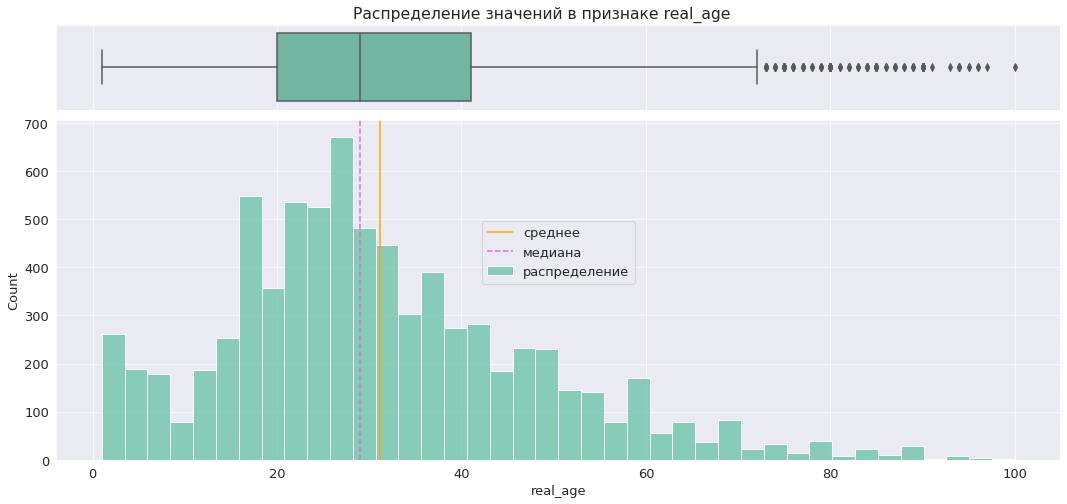

In [6]:
hist_box (labels, 'real_age', bins=40)

- Распределение со смещением вправо, среднее больше медианы, что логично и объясняется демографической ситуацией в мире.
- Наличие выбросов может отрицательно повлиять на качество обучения.

### Вывод фотографий на экран

Зафиксируем генератор случайных чисел

In [7]:
np.random.seed(2007)
rand_index = [int(x) for x in np.random.rand(16) * len(labels)]

Напечатаем на экране 16 фотографий

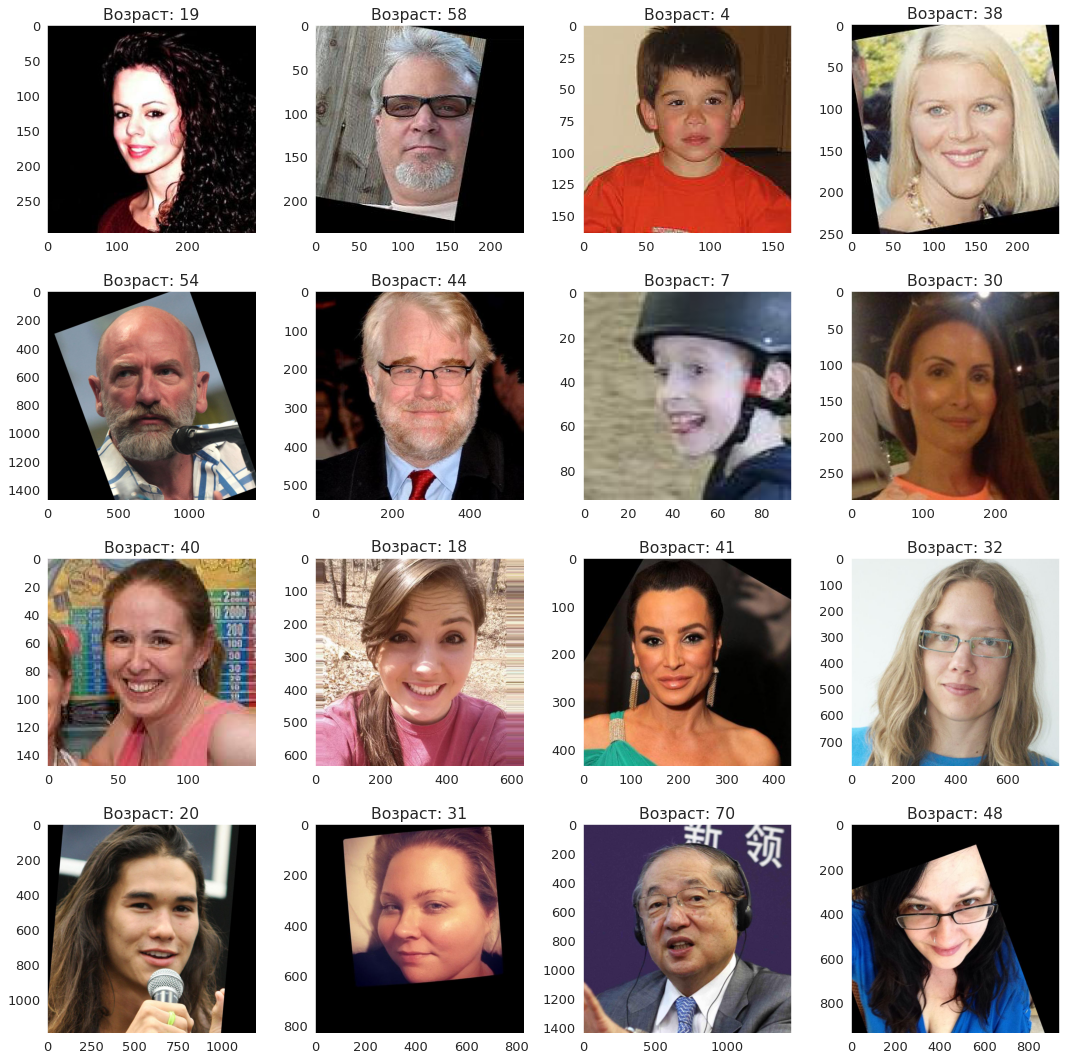

In [8]:
fig = plt.figure(figsize=(15,15))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image=Image.open('/datasets/faces/final_files/'+
                     labels.loc[rand_index[i]]['file_name'])
    plt.imshow(image)
    plt.grid(False)
    plt.tight_layout()
    plt.title(f'Возраст: {labels.loc[rand_index[i]]["real_age"]}')

- Присутствуют фотографии как заполняющие весь кадр, так и заполняющие частично со смещением.
- Ракурс на фотографиях: анфас и профиль, 3/4 и т.д., положение лиц меняется.
- На фотографиях наблюдаются разные эмоции.
- Присутствуют люди разного пола, национальсти, с реквизитом, перекрывающим лицо (микрофон, очки, наушники).
- Фотографии различного качества и размера.

### Вывода по результату EDA

- Предполагаю, что модель будет лучше обучаться на данных в пределах нормального распределения: возраст людей от 10 до 50 лет, с ракурсом анфас, с нейтральной эмоцией на фото, без реквизита.
- Также считаю, что поворот некоторых фотографий сделан намеренно по одной из двух причин:
    1. для избежания переобучения (выполнено увеличение объёма данных через трансформацию существующего датасета - аугментация),
    2. для выравнивания положения лица на фото, что более вероятно.

## Обучение модели

- Поскольку нейронные сети обучаются значительное количество времени, машинное обучение в данном проекте производится на сервере с графической картой (GPU) [Yandex Compute Cloud](https://cloud.yandex.ru/services/compute), поэтому код и результат вывода на экран оформлены в ячейках типа `Markdown`.

### Код, выполненный в GPU-тренажере

```python
'''Импорт библиотек'''
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

'''Загрузка обучающей выборки (путь к файлам находится в параметре path)'''
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    '''подключим динамическую загрузку данных;
       сформируем батчи с изображениями;
       укажем загрузчику размер валидационной выборки (25% случайных объектов);
       приведем яркость изображений к диапазону [0, 1]'''
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    '''извлечение данных'''
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,                # датафрейм, содержащий x_col и y_col
        directory=path + 'final_files/', # папка, в которой хранится датасет
        x_col='file_name',               # наименование признака
        y_col='real_age',                # наименование таргета
        target_size=(224, 224),          # к какому размеру приводить изображения (нейронным сетям нужны одинаковые)
        batch_size=16,                   # размер батча
        class_mode='raw',                # в каком виде выдавать метки классов, 'raw' - массив значений в столбцах y_col
        subset='training',               # указываем, что это загрузчик для обучающей выборки
        seed=2007)                       # фиксируем генератор случайных чисел (значение для обуч. и валид. одинаковое)
    return train_datagen_flow

'''Загрузка валидационной выборки (путь к файлам находится в параметре path)'''
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    '''подключим динамическую загрузку данных;
       сформируем батчи с изображениями;
       укажем загрузчику размер валидационной выборки (25% случайных объектов);
       приведем яркость изображений к диапазону [0, 1]'''
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    '''извлечение данных'''
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,                # датафрейм, содержащий x_col и y_col
        directory=path + 'final_files/', # папка, в которой хранится датасет
        x_col='file_name',               # наименование признака
        y_col='real_age',                # наименование таргета
        target_size=(224, 224),          # к какому размеру приводить изображения (нейронным сетям нужны одинаковые)
        batch_size=16,                   # размер батча
        class_mode='raw',                # в каком виде выдавать метки классов, 'raw' - массив значений в столбцах y_col
        subset='validation',             # указываем, что это загрузчик для валидационной выборки
        seed=2007)                       # фиксируем генератор случайных чисел (значение для обуч. и валид. одинаковое)
    return test_datagen_flow


'''Создание модели (параметр input_shape - размер данных в первом слое)'''
def create_model(input_shape):
    '''подключим класс алгоритма Adam для автоподбора шага, что ускоряет обучение модели
       и подберем скорость обучения (learning rate) - это шаг градиентного спуска, с которого алгоритм стартует.'''
    optimizer = Adam(learning_rate=0.0003)
    '''backbone — костяк архитектуры ResNet50;
       50 означает количество слоёв в сети;
       weights='imagenet' — инициализация весов, ImageNet — название датасета, на котором сеть обучалась;
       include_top=False — в конце архитектуры ResNet не добавлять слои GlobalAveragePooling2D и Dense.'''
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    '''инициализируем нейронную сеть, зададим класс Sequential,
       этот класс применяется для моделей, в которых слои идут последовательно.'''
    model = Sequential()
    '''указываем, как устроена нейронная сеть с добавлением набор нейронов с общим входом и выходом - слоёв'''
    '''добавляем слои архитектуры ResNet50'''
    model.add(backbone)
    '''добавляем пулинг - объединение с целью уменьшения количества параметров модели -
       с окном во весь тензор, возвращающий среднее значение из группы пикселей внутри канала'''
    model.add(GlobalAveragePooling2D())
    '''добавляем полносвязный слой с 1 нейроном (т.к. задача регрессии) и функцией активации "relu";
       положительные прогнозы функция ReLU не меняет, а все отрицательные — приводит к нулю,
       чисел меньше 0 быть не может.'''
    model.add(Dense(units=1, activation='relu'))
    '''указываем, как обучается нейронная сеть c функцией потерь отличной от метрики'''
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

'''Запуск модели'''
'''model - созданная модель,
   train_data - обучающая выборка,
   test_data - тестовая выборка,
   batch_size - размер батчей данных,
   epochs - количество эпох для обучения модели,
   steps_per_epoch - количество батчей в наборе данных,
   validation_steps - общее количество шагов при выполнении проверки в конце каждой эпохи.
   verbose=2 - для выполнения кода в Jupiter Notebook
   shuffle=True - перемешать данные перед каждой эпохой
   '''
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    '''обучаем модель'''
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2, shuffle=True)
    return model
```

### Результат вывода на экран

```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/15
2022-09-18 20:42:08.860858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-18 20:42:10.983557: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 77s - loss: 194.5461 - mae: 10.4593 - val_loss: 288.8870 - val_mae: 12.8418
Epoch 2/15
356/356 - 39s - loss: 97.0989 - mae: 7.5329 - val_loss: 237.9378 - val_mae: 11.5464
Epoch 3/15
356/356 - 38s - loss: 59.7439 - mae: 5.9100 - val_loss: 111.0890 - val_mae: 7.8951
Epoch 4/15
356/356 - 38s - loss: 39.3192 - mae: 4.8658 - val_loss: 88.0762 - val_mae: 7.1049
Epoch 5/15
356/356 - 38s - loss: 25.2851 - mae: 3.9153 - val_loss: 80.3512 - val_mae: 6.7162
Epoch 6/15
356/356 - 38s - loss: 21.5497 - mae: 3.5850 - val_loss: 88.8303 - val_mae: 7.1759
Epoch 7/15
356/356 - 38s - loss: 17.3400 - mae: 3.2068 - val_loss: 85.9963 - val_mae: 7.0838
Epoch 8/15
356/356 - 38s - loss: 16.0277 - mae: 3.0666 - val_loss: 81.5113 - val_mae: 6.8365
Epoch 9/15
356/356 - 38s - loss: 14.5080 - mae: 2.9062 - val_loss: 82.6491 - val_mae: 6.9768
Epoch 10/15
356/356 - 38s - loss: 12.5573 - mae: 2.7336 - val_loss: 77.9379 - val_mae: 6.6467
Epoch 11/15
356/356 - 38s - loss: 11.6694 - mae: 2.6126 - val_loss: 83.4258 - val_mae: 7.1175
Epoch 12/15
Epoch 13/15
356/356 - 38s - loss: 11.3880 - mae: 2.5875 - val_loss: 101.3660 - val_mae: 7.9141
356/356 - 38s - loss: 12.4803 - mae: 2.7426 - val_loss: 82.7668 - val_mae: 6.9012
Epoch 14/15
356/356 - 38s - loss: 23.0722 - mae: 3.4300 - val_loss: 144.5923 - val_mae: 8.9901
Epoch 15/15
356/356 - 38s - loss: 35.8264 - mae: 4.5460 - val_loss: 89.3392 - val_mae: 6.9140

119/119 - 9s - loss: 89.3392 - mae: 6.9140
Test MAE: 6.9140
```

- Наблюдается разница между значениями MAE на обучающей и тестовой выборках, но качество на тесте удовлетворяет заданному заказчиком условию MAE ≤ 8.

## Выводы

- Проведен исследовательский анализ данных, изучено распределение возраста в выборке, выдвинуты гипотезы о том, как результаты исследования повлияют на обучение модели.
- Проведено машинное обучение нейронной сети.
- При обучении модели подобрана оптимальная архитектура и гиперпараметры при которых определяется возраст человека по фотографии со средней абсолютной ошибкой на тесте не больше 8 лет, цель достигнута.
- Использование нейронных сетей позволяет проводить машинное обучение с большими данными и достигать необходимого качества, что стало возможно с развитием вычислительных технологий, способных обрабатывать архитектуру искусственного интеллекта.